# Movie Recommender System

In this project, we build a recommender system to recommend movies to the users. Specifically, the recommendations are based on the probability of a user interacting with a unwatched movie, i.e. the recommendations are chosen as the movies with the highest interacting probability. The task of the recommender system is to try to accurately predict this probability of any user i interacting with any unwatched movie j in the dataset.

There are different types of recommender systems, i.e. content-based filtering, collaborative filtering and hybrid. Depending on the dataset, different types of systems may be more advantageous and preferred. The dataset used here is the Movielens dataset from Kaggle (https://www.kaggle.com/sherinclaudia/movielens).

The dataset contains the genres that each movie belongs to, with which we are able to build a content-based model. A content-based model is more interpretable and usually less computationally complex making it more easily scaled to larger dataset. However, a downside of a content-based model is that it tends to always recommend items to a user that are similar to what this user has already interacted with before. This restricts the diversity of the recommendations. In contrast, a model using collaborative filtering also utilize the information from other users to make the recommendations so it can usually recommend items with higher diversity. Therefore, here we build a model using collaborative filtering to make diverse recommendations to the users!

Collaborative filtering can also be done in various ways. We choose a neural-network-based model, which has been shown to outperform the matrix factorization approach because of the extra nonlinearity included in the neural network. The neural collaborative filtering was originally proposed in 2017 (https://doi.org/10.1145/3038912.3052569). We will preprocess the dataset to a form that can be fed to a neural collaborative model and then we build and train the model. Finally, we compare the performance of the model to a baseline model that makes recommendations purely based on popularity.

## Data preparation & preprocessing

### Import libraries

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import *

### Load the data

In [2]:
movie_data = pd.read_csv('./data/movies.dat', sep = '::', engine='python')
movie_data.columns = ['movie_id', 'movie_name', 'category']
movie_data.dropna(inplace = True)
print(movie_data.head())
print(movie_data.shape)

   movie_id                          movie_name                      category
0         2                      Jumanji (1995)  Adventure|Children's|Fantasy
1         3             Grumpier Old Men (1995)                Comedy|Romance
2         4            Waiting to Exhale (1995)                  Comedy|Drama
3         5  Father of the Bride Part II (1995)                        Comedy
4         6                         Heat (1995)         Action|Crime|Thriller
(3882, 3)


In [3]:
rating_data = pd.read_csv("./data/ratings.dat", sep = '::', engine='python')
rating_data.columns = ['user_id','movie_id','rating','timestamp']
rating_data.dropna(inplace = True)
print(rating_data.head())
print(rating_data.shape)

   user_id  movie_id  rating  timestamp
0        1       661       3  978302109
1        1       914       3  978301968
2        1      3408       4  978300275
3        1      2355       5  978824291
4        1      1197       3  978302268
(1000208, 4)


In [4]:
# user_data = pd.read_csv("./data/users.dat", sep = '::', engine = 'python')
# user_data.columns = ['user_id','gender', 'age', 'occupation', 'zip_code']
# user_data.dropna(inplace = True)
# print(user_data.head())
# print(user_data.shape)

Instead of directly using the explicit feedback (the rating ranging from 1 to 5), we transfer it to implicit binary feedback (0 for no interaction and 1 for observed interaction). Also, there are usually more implicit feedback available in most websites. The data preprocessing is done by using the ```ImRecomDataPreprocessor``` class written in the preprocessing.py file.

In [5]:
preprocessor = ImRecomDataPreprocessor()
dataset, (num_users, num_items), (user2idx, item2idx) = preprocessor.fit(rating_data, 'user_id', 'movie_id', 'rating', 'timestamp')


We take a look at how many positive samples (there is an interaction) and negative samples (there is no interaction) there are:

In [43]:
print(f'There are {num_users} users and {num_items} movies resulting in {num_users * num_items} user-movie pairs.')
print(f'In the total {len(dataset)} pairs, the numbers of negative (0) and positive (1) interactions are')
print(dataset['rating'].value_counts())
inter_rate = 100 * len(dataset[dataset['rating'] == 1]) / (num_users * num_items)
print(f'The interaction rate is {inter_rate: .2f}%, which is quite sparse.')
dataset.head()

There are 6040 users and 3706 movies resulting in 22384240 user-movie pairs.
In the total 22384240 pairs, the numbers of negative (0) and positive (1) interactions are
0    21384032
1     1000208
Name: rating, dtype: int64
The interaction rate is  4.47%, which is quite sparse.


,user_id,movie_id,rating,timestamp
0,0,0,1,978302109.0
1,1,0,1,978460739.0
2,2,0,1,977972750.0
3,3,0,1,977979726.0
4,4,0,1,977935511.0


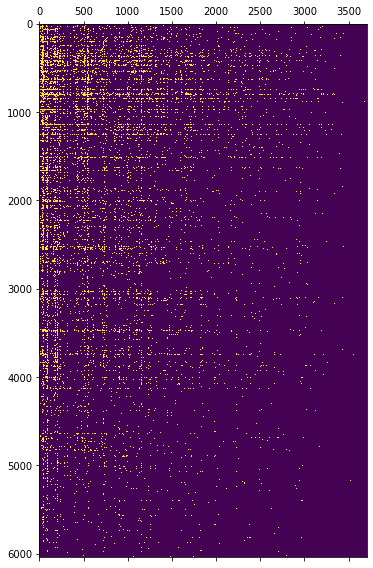

In [44]:
fig, ax = plt.subplots(figsize=(16, 16* num_items / num_users))
ax.matshow(pd.crosstab(dataset['user_id'], dataset['movie_id'], dataset['rating'], aggfunc = np.sum).to_numpy())

As could be seen in the above summary of the data as well as the image representation of the user-movie interaction matrix, the positive samples are quite sparse, which is expected for the most websites. There are so many items so majority of the users probably only have interacted with a tiny portion of the items, and vice versa.

In [8]:
# print(user2idx)
# print(item2idx)

Let's prepare the training and validation data to train the model.

In [9]:
(train_X, train_y), (val_X, val_y) = preprocessor.create_dataset(4, 100)

We have 21384032 negative training data.

Before leaving one out, we have 1000208 positive training data.

The least and most interaction of a user among all users: 20, 2314 



/Users/xiejiayu/Documents/ML Projects/Movie Recommender System/preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group_rank'] = df.groupby([self.user_col])[self.time_col].rank(method = 'first', ascending = False)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
After leaving one out, we have 994168 positive training data and 6040 test data.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Before negative sampling, we have 994168 positive training data and 6040 positive test data.

We should sample 4000832 negative training data and 604000 negative test data.

We actually sampled 3737105 negitive training data and 604000 negative test data.

After negative sampling, we have 4731273 training data and 610040 test data.



In [10]:
print(len(train_X), len(train_y), len(val_X), len(val_y))
num_train = len(train_X)
num_val = len(val_X)

4731273 4731273 610040 610040


In [11]:
train_dataset = ImRecomDatasetTrain(train_X, train_y)

val_dataset = ImRecomDatasetTest(val_X, val_y, 'user_id', 'movie_id', 'rating')

## Build the model

Here we build a neural collaborative filtering model composed of a generalized matrix factorization part (linear) and a multilayer perceptron part (nonlinear).

### Import libraries

In [12]:
import torch
import torch.nn as nn
from evaluation_metrics import *

### Write the model class

In [13]:
class Model(nn.Module):
    def __init__(self, num_users, num_products, embedding_dim_mf = 16, embedding_dim_mlp = 16, hidden_config = [64, 32, 16]):
        super().__init__()

        # Matrix factorization (MF) embedding
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings = num_users, embedding_dim = embedding_dim_mf)
        self.embedding_product_mf = torch.nn.Embedding(num_embeddings = num_products, embedding_dim = embedding_dim_mf)

        # Multilayer perceptron (MLP) embedding
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings = num_users, embedding_dim = embedding_dim_mlp)
        self.embedding_product_mlp = torch.nn.Embedding(num_embeddings = num_products, embedding_dim = embedding_dim_mlp)

        # Hidden layers of MLP
        self.hiddens = torch.nn.ModuleList()
        self.hiddens.append(torch.nn.Linear(2 * embedding_dim_mlp, hidden_config[0]))
        for idx in range(len(hidden_config) - 1):
            self.hiddens.append(torch.nn.Linear(hidden_config[idx], hidden_config[idx + 1]))

        # Output head for rating
        self.head = torch.nn.Linear(in_features = hidden_config[-1] + embedding_dim_mf, out_features = 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        user_embeddings_mlp = self.embedding_user_mlp(user_indices)
        product_embeddings_mlp = self.embedding_product_mlp(item_indices)
        user_embeddings_mf = self.embedding_user_mf(user_indices)
        product_embeddings_mf = self.embedding_product_mf(item_indices)

        # MF part
        mf_vector = torch.mul(user_embeddings_mf, product_embeddings_mf)
        mf_vector = torch.nn.Dropout(0.2)(mf_vector)

        # MLP part        
        mlp_vector = torch.cat([user_embeddings_mlp, product_embeddings_mlp], dim = -1)  

        for idx in range(len(self.hiddens)):
            mlp_vector = self.hiddens[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)
        mlp_vector = torch.nn.Dropout(0.2)(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim = -1)
        output = self.sigmoid(self.head(vector))
        return output


## Train the model

### Write the training loop

In [14]:
################# BUILDING MODEL ###################
import time

def experiment(train_dataset, val_dataset, args):
    model = Model(num_users, num_items, hidden_config = [32, 16, 8])

    print(model)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle = False)
    
    if args.gpu:
        # ****** Copy model to device ****** #
        model.to(device)
    
    # ====== Loss function ====== #
    lossfunction = nn.BCELoss(reduction = 'sum') 

    optimizer = torch.optim.Adam(model.parameters())

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_hr = []
    list_ndcg = []
    
    best_hr = 0.0
    best_ndcg = 0.0

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        t0 = time.time()
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        train_loss = 0 # to sum up each batch

        for batch_X, batch_y in train_dataloader:
            optimizer.zero_grad()
            
            if args.gpu:
                # ****** Transfer data to GPU ****** #
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

            pred_y = model(batch_X[:, 0], batch_X[:, 1])

            loss = lossfunction(pred_y.view(-1), batch_y)
            
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
                                                
        train_loss = train_loss / num_train
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)
        
        print(f'{time.time() - t0} seconds')

        # ====== Validation ====== #
        model.eval() # Set the model be 'evaluate mode' 
        hr = 0
        ndcg = 0
           
        with torch.no_grad():
            
            for batch_X, batch_y in val_dataloader:
                
                batch_X, batch_y = batch_X[0], batch_y[0]

                if args.gpu:
                    # ****** Transfer data to GPU ****** #
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)

                pred_y = model(batch_X[:, 0], batch_X[:, 1])
                
                _, top_indices = torch.topk(pred_y.view(-1), args.top)

                if args.gpu:
                    true_item_idx = np.argmax(batch_y.cpu().numpy().tolist())
                else:
                    true_item_idx = np.argmax(batch_y.numpy().tolist())

                hr += evaluate_hr(top_indices, true_item_idx)
                ndcg += evaluate_ndcg(top_indices, true_item_idx, args.gpu)
                
        hr = hr / num_users
        ndcg = ndcg / num_users
        
        list_hr.append(hr)
        list_ndcg.append(ndcg)

        if (hr > best_hr and ndcg > best_ndcg) or (hr == best_hr and ndcg > best_ndcg) or (hr > best_hr and ndcg == best_ndcg):
            print(f"Epoch {epoch}: Performence improved! HR: {best_hr: .4f} -> {hr: .4f}, NDCG: {best_ndcg: .4f} -> {ndcg: .4f}.")
            best_hr = hr
            best_ndcg = ndcg
            torch.save(model.state_dict(), './model/model_dict_best.pt')
        else:
            print(f"Epoch {epoch}: Neither the best HR nor the best NDCG increased, or at least one of them decreased.")
        
        print(f'Epoch: {epoch}, Train Loss: {train_loss: .4f}, HR: {hr: .4f}, NDCG: {ndcg: .4f}')
        print('~' * 100)
        
    return list_epoch, list_train_loss, list_hr, list_ndcg


### Train

To evaluate the performance of the model, we choose to use hit ratio (HR) and normalized discounted cumulative gain (NDCG) as the metrics (https://doi.org/10.1145/2806416.2806504).

In [15]:
import argparse
import random

In [16]:
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.gpu = False
args.epoch = 30
args.batch_size = 256
args.top = 10

list_epoch, list_train_loss, list_hr, list_ndcg = experiment(train_dataset, val_dataset, args)


Model(
  (embedding_user_mf): Embedding(6040, 16)
  (embedding_product_mf): Embedding(3706, 16)
  (embedding_user_mlp): Embedding(6040, 16)
  (embedding_product_mlp): Embedding(3706, 16)
  (hiddens): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (head): Linear(in_features=24, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
1116.3378438949585 seconds
Epoch 0: Performence improved! HR:  0.0000 ->  0.4884, NDCG:  0.0000 ->  0.2720.
Epoch: 0, Train Loss:  0.3887, HR:  0.4884, NDCG:  0.2720
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1117.8445188999176 seconds
Epoch 1: Performence improved! HR:  0.4884 ->  0.4992, NDCG:  0.2720 ->  0.2787.
Epoch: 1, Train Loss:  0.3690, HR:  0.4992, NDCG:  0.2787
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1124.2263259887695 seconds
Epoch 29: Neither the best HR nor the best NDCG increased, or at least one of them decreased.
Epoch: 29, Train Loss:  0.2594, HR:  0.6598, NDCG:  0.3910
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Display the training history

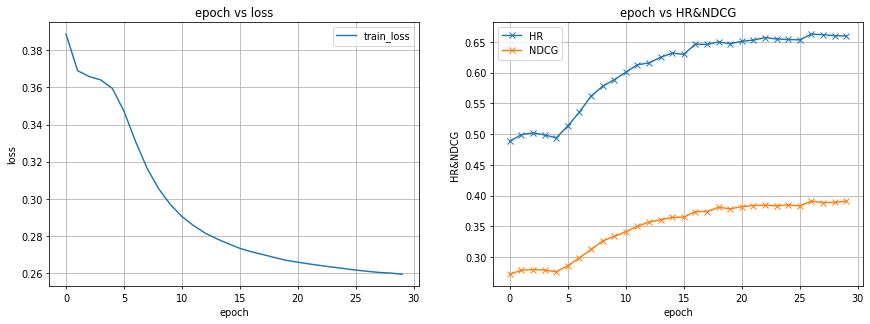

In [17]:
fig = plt.figure(figsize = (15, 5), dpi = 70)

# ====== Plot Loss ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# # ====== Plot Metric ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_hr, marker='x', label='HR')
ax2.plot(list_epoch, list_ndcg, marker='x', label='NDCG')
ax2.set_xlabel('epoch')
ax2.set_ylabel('HR&NDCG ')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs HR&NDCG')

plt.show()

We see that after 30 epochs training the loss for the training set decreased to ~ 0.26 and the NR $ NDCG pf the validation set increased to ~0.39 and ~0.66, respectively.

Load the model

In [18]:
# model = Model(num_users, num_items, hidden_config = [32, 16, 8])
# model.load_state_dict(torch.load('./model/model_dict_best.pt'))

## Compare to a baseline model

Let's compare the performance of the neural collaborative model with a baseline model. The baseline model makes recommendation purely based on the popularity of the items, i.e. the more popular a movie is the more probable it is regarded to be interacted by the users.

In [2]:
import seaborn as sns

In [20]:
movie2posnum = dataset[dataset['rating'] == 1].groupby('movie_id')['rating'].count().reset_index()
movie2posnum = movie2posnum.rename(columns = {'rating': 'count'})

In [23]:
user_groups = list(pd.merge(pd.concat([val_X, val_y], axis = 1), movie2posnum, on = 'movie_id').groupby('user_id'))
print(len(user_groups))

6040


In [24]:
hr_base = 0
ndcg_base = 0
top = 10

for item in user_groups:
    
    temp_df = item[1].sort_values(by = ['count'], ascending = False).reset_index(drop = True)
    
    top_list = temp_df['rating'].tolist()[:top]
    
    if 1 in top_list:

        hr_base += 1.

        ndcg_base += 1. / np.log2(top_list.index(1) + 2.)

    else:
        pass

hr_base /= num_users
ndcg_base /= num_users

In [8]:
print(hr_base, ndcg_base)

0.5125827814569537 0.29481712465112364


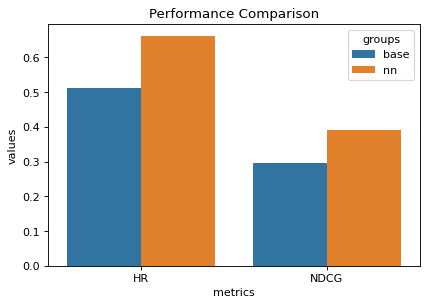

In [9]:
results = pd.DataFrame({'groups': ['base', 'base', 'nn', 'nn'], 'metrics': ['HR', 'NDCG', 'HR', 'NDCG'], 'values': [hr_base, ndcg_base, 0.6627, 0.3910]})

plt.figure(dpi = 80)
sns.barplot(data = results, x = 'metrics', y = 'values', hue = 'groups')
plt.title('Performance Comparison')
plt.show()

In the bar plot, it is clear that the neural collaborative filtering model outperforms the baseline model 29.29% in HR and 32.62% in NDCG!

Due to the limited computational resources, we stopped the training at the 30th epoch and didn't tune the hyper-parameters. Although at around the 30th epoch the training curve and metric curves tend to saturate, there has not been a clear sign of overfitting yet. Therefore, training for more epochs may give a better result. Also, if hyper-parameters tuning is performed, the result may be further improved.